In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dist_ir.ir import Module
from dist_ir.ir import Topology
from dist_ir.ir.type import Float
from dist_ir.ir.type import Tensor
from dist_ir.executor.cost_inference import CostModel
from dist_ir.executor import DistributedSimulator
from dist_ir.transforms import DataParallelTransform

In [3]:
def run_data_parallel_experiment(num_devices, batch_size=16, num_classes=10,
                                 input_dim=4, hidden_dim=2, bandwidth=2):
    module = Module()
    topology = Topology()

    devices = []
    for i in range(num_devices):
        devices.append(topology.add_device("gpu"))
    for i in range(num_devices):
        for j in range(i+1, num_devices):
            topology.set_bandwidth(devices[i], devices[j], bandwidth)

    x = module.add_input_value("x", Tensor(Float(), (batch_size, input_dim), device=devices[0]))
    z = module.add_input_value("z", Tensor(Float(), (batch_size, num_classes), device=devices[0]))
    wA = module.add_input_value("wA", Tensor(Float(), (input_dim, hidden_dim), device=devices[0]))
    wB = module.add_input_value("wB", Tensor(Float(), (hidden_dim, num_classes), device=devices[0]))
    a = module.add_op("MatMul", "MatMul0", inputs=[x, wA], output_names=["a"])
    y = module.add_op("MatMul", "MatMul1", inputs=[a, wB], output_names=["y"])
    l = module.add_op(
        "Loss", "Loss", inputs=[y, z], attributes={"N": batch_size}, output_names=["l"]
    )
    dl = module.add_op(
        "LossGrad",
        "LossGrad",
        inputs=[y, z],
        attributes={"N": batch_size},
        output_names=["dl"],
    )
    da, dwB = module.add_op(
        "MatMulGrad", "MatMul1Grad", inputs=[a, wB, dl], output_names=["da", "dwB"]
    )
    dx, dwA = module.add_op(
        "MatMulGrad", "MatMul0Grad", inputs=[x, wA, da], output_names=["dx", "dwA"]
    )
    module.set_outputs([dwA, dwB])
    module.finalize()
    transform = DataParallelTransform(
        batch_dims={"x": 0, "z": 0},
        reduction_params={
            "dwA": {"op_type": "Allreduce"},
            "dwB": {"op_type": "Allreduce"},
        },
        devices=devices,
    )
    transformed_module = transform.apply(module)
    transformed_module.finalize()
    device_speeds = {"gpu": 1.0e13}
    cost_model = CostModel(topology, device_speeds)
    simulator = DistributedSimulator(cost_model)
    simulator_state = simulator.simulate(transformed_module)
    execution_time = max([simulator_state.timestamps[device] for device in devices])
    return execution_time

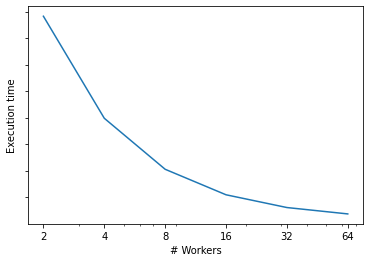

In [4]:
all_num_workers = [2, 4, 8, 16, 32, 64]
all_execution_times = []
for num_workers in all_num_workers:
    all_execution_times.append(run_data_parallel_experiment(num_workers, batch_size=1024,
                                                            input_dim=512, hidden_dim=1024,
                                                            num_classes=100))
frame = plt.gca()
plt.plot(all_num_workers, all_execution_times)
plt.xlabel("# Workers")
plt.ylabel("Execution time")
plt.xscale("log")
plt.xticks(all_num_workers)
_ = frame.axes.xaxis.set_ticklabels(all_num_workers)
_ = frame.axes.yaxis.set_ticklabels([])